#  Lab Assignment Seven: Sequential Network Architectures

Name 1: Jadon Swearingen (5000)
Name 2: Ephraim Sun (7000)
Name 3: Adeeb Abdul Taher (7000)


In this lab, you will select a prediction task to perform on your dataset, evaluate a sequential architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify. 

### Dataset Selection

Dataset: https://www.kaggle.com/datasets/rajatkumar30/fake-news

We have chosen a fake news dataset where given the title and text of the article, we should predict if the news is fake or real. 

### Preparation

[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# import optuna
# import itertools
# import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

mpl.style.use("seaborn-v0_8-deep")
mpl.rcParams["figure.figsize"] = (20, 5)
mpl.rcParams["figure.dpi"] = 100
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

/var/folders/sd/j5p08m515kd7n9549lkkz_q40000gn/T/ipykernel_80392/1941070421.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer

In [3]:
nltk.download("vader_lexicon")
nltk.download("punkt")
nltk.download("stopwords")


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ephraim888sun/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ephraim888sun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ephraim888sun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Load dataset

df = pd.read_csv("./dataset/news.csv")

df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


#### Preprocess Data

This function performs several preprocessing steps on the input DataFrame:
1. Converts the 'title' and 'text' columns to string type to ensure consistency.
2. Encodes the 'label' column, mapping 'FAKE' to 1 and 'REAL' to 0, to prepare for machine learning algorithms.
3. Drops the 'Unnamed: 0' column which is often an artifact from reading files with an index.
4. Splits the DataFrame into two separate DataFrames: one containing 'title' and 'label' columns, and the other containing 'text' and 'label' columns.

In [5]:
def pre_process(df):
    """
    Parameters:
    - df (pd.Dataframe): The DataFrame to be preprocessed

    Returns: 
    - Tuple[pd.DataFrame, pd.DataFrame]: A tuple of two DataFrames. The first DataFrame contains 'title' and 'label' columns, 
        and the second DataFrame contains 'text' and 'label' columns.

    """

    columns = ["title", "text"]
    for col in columns:
        df[col] = df[col].astype(str)  # Convert each column to string

    # Map 'label' values from 'FAKE'/'REAL' to 1/0
    df["label"] = df["label"].map({"FAKE": 1, "REAL": 0})

    # Remove the 'Unnamed: 0' column, if it exists, as it's usually an artifact
    df = df.drop(["Unnamed: 0"], axis=1)

    # Split the DataFrame into two: one with 'title' and 'label', and one with 'text' and 'label'
    df_title = df[["title", "label"]]
    df_text = df[["text", "label"]]

    # Define the directory where you want to save the pickle files
    directory_path = "D:\\Projects\\Fake News Detection\\Data\\"

    # Export df_title as a pickle file
    # df_title.to_pickle(directory_path + "df_title.pkl")

    # Export df_text as a pickle file
    # df_text.to_pickle(directory_path + "df_text.pkl")

    print("DataFrames exported as pickle files successfully.")

    return df_title, df_text

In [6]:
def num_characters(df, col_name):
    """
    Adds a new column to the DataFrame containing the number of characters in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.
    - col_name: str. The name of the column containing the messages.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """

    df["Characters"] = df[col_name].apply(len)
    return df


def num_sentences(df, col_name):
    """
    Adds a new column to the DataFrame containing the number of sentences in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.
    - col_name: str. The name of the column containing the messages.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """
    df["Sentences"] = df[col_name].apply(lambda x: len(nltk.sent_tokenize(x)))
    return df


def num_words(df, col_name):
    """
    Adds a new column to the DataFrame containing the number of words in each message.

    Parameters:
    - df: DataFrame. The DataFrame to which the new column will be added.
    - col_name: str. The name of the column containing the messages.

    Returns:
    - DataFrame. The original DataFrame with a new column added.
    """
    df["Words"] = df[col_name].apply(lambda x: len(nltk.word_tokenize(x)))
    return df


In [7]:
def pie_plot(df, col_name):
    """
    Creates a pie plot to show the distribution of real and fake news in the DataFrame.

    Parameters:
    - df: DataFrame. The DataFrame containing the data.
    - col_name: str. The name of the column containing the labels.

    Returns:
    - None. Displays a pie plot.
    """
    sizes = df["label"].value_counts()
    labels = ["Real", "Fake"]
    colors = ["#ff9999", "#66b3ff"]

    plt.pie(
        sizes,
        autopct="%1.1f%%",
        colors=colors,
        startangle=90,
        explode=(0.1, 0),
        shadow=True,
    )

    plt.title("Distribution of Real and Fake News in " + col_name)
    plt.legend(labels, title="News Type", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

In [8]:
def plot_distribution_features(df, features, col_name):
    """
    Plot distributions of specified features in a DataFrame, comparing 'Real' and 'Fake' news.

    Parameters:
    - df: DataFrame containing the data.
    - features: List of strings, names of the columns for which to plot the distributions.

    Each feature's distribution is plotted in a separate row, with 'Real' news in blue and 'Fake' news in pink.
    """
    # Create a figure with subplots arranged in 3 rows and 1 column
    fig, axes = plt.subplots(
        nrows=len(features), ncols=1, figsize=(15, 6 * len(features))
    )

    for i, feature in enumerate(features):
        # Plot distribution for 'Real' news
        sns.histplot(
            df[df["label"] == 0][feature],
            kde=True,
            color="#66b3ff",
            label="Real",
            ax=axes[i],
        )
        # Plot distribution for 'Fake' news
        sns.histplot(
            df[df["label"] == 1][feature],
            kde=True,
            color="#ff9999",
            label="Fake",
            ax=axes[i],
        )
        # Setting the title for each subplot
        axes[i].set_title(f"{feature} Distribution for {col_name} dataset")
        # Setting the labels for each subplot
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Count")
        # Adding legend to each subplot
        axes[i].legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [9]:
df_title, df_text = pre_process(df)

DataFrames exported as pickle files successfully.


In [10]:
df_title

,title,label
0,You Can Smell Hillary’s Fear,1
1,Watch The Exact Moment Paul Ryan Committed Pol...,1
2,Kerry to go to Paris in gesture of sympathy,0
3,Bernie supporters on Twitter erupt in anger ag...,1
4,The Battle of New York: Why This Primary Matters,0
...,...,...
6330,State Department says it can't find emails fro...,0
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1
6332,Anti-Trump Protesters Are Tools of the Oligarc...,1
6333,"In Ethiopia, Obama seeks progress on peace, se...",0


In [11]:
df_text

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",1
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,1
2,U.S. Secretary of State John F. Kerry said Mon...,0
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1
4,It's primary day in New York and front-runners...,0
...,...,...
6330,The State Department told the Republican Natio...,0
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1
6332,Anti-Trump Protesters Are Tools of the Oligar...,1
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",0


In [12]:
df_title = num_characters(df_title, "title")
df_title = num_sentences(df_title, "title")
df_title = num_words(df_title, "title")

In [13]:
df_text = num_characters(df_text, "text")
df_text = num_sentences(df_text, "text")
df_text = num_words(df_text, "text")

In [14]:
df_title

,title,label,Characters,Sentences,Words
0,You Can Smell Hillary’s Fear,1,28,1,7
1,Watch The Exact Moment Paul Ryan Committed Pol...,1,85,1,16
2,Kerry to go to Paris in gesture of sympathy,0,43,1,9
3,Bernie supporters on Twitter erupt in anger ag...,1,84,1,18
4,The Battle of New York: Why This Primary Matters,0,48,1,10
...,...,...,...,...,...
6330,State Department says it can't find emails fro...,0,69,1,12
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1,59,1,16
6332,Anti-Trump Protesters Are Tools of the Oligarc...,1,66,1,9
6333,"In Ethiopia, Obama seeks progress on peace, se...",0,67,1,13


In [15]:
df_text

,text,label,Characters,Sentences,Words
0,"Daniel Greenfield, a Shillman Journalism Fello...",1,7518,87,1473
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,2646,26,517
2,U.S. Secretary of State John F. Kerry said Mon...,0,2543,16,484
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,2660,17,498
4,It's primary day in New York and front-runners...,0,1840,21,376
...,...,...,...,...,...
6330,The State Department told the Republican Natio...,0,4076,27,726
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1,14323,49,2594
6332,Anti-Trump Protesters Are Tools of the Oligar...,1,11974,100,2137
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",0,6991,40,1313


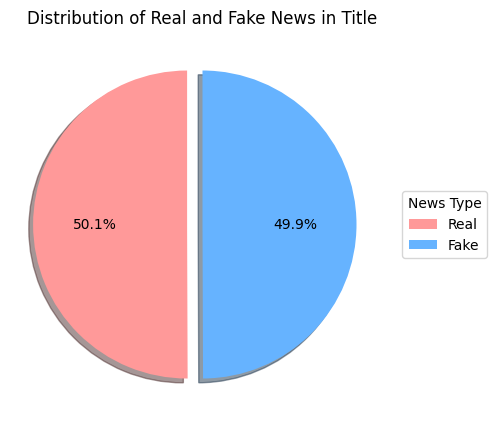

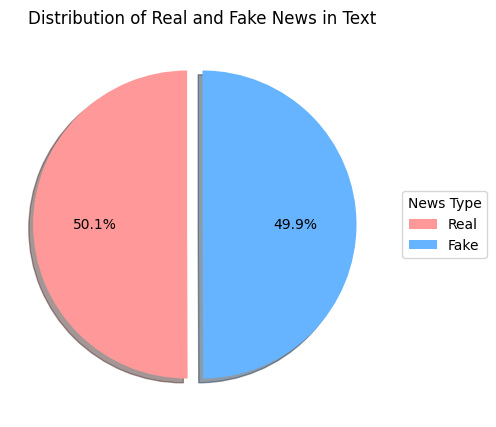

In [16]:
pie_plot(df_title, "Title")
pie_plot(df_text, "Text")


In [17]:
df_text

,text,label,Characters,Sentences,Words
0,"Daniel Greenfield, a Shillman Journalism Fello...",1,7518,87,1473
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,2646,26,517
2,U.S. Secretary of State John F. Kerry said Mon...,0,2543,16,484
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,2660,17,498
4,It's primary day in New York and front-runners...,0,1840,21,376
...,...,...,...,...,...
6330,The State Department told the Republican Natio...,0,4076,27,726
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,1,14323,49,2594
6332,Anti-Trump Protesters Are Tools of the Oligar...,1,11974,100,2137
6333,"ADDIS ABABA, Ethiopia —President Obama convene...",0,6991,40,1313


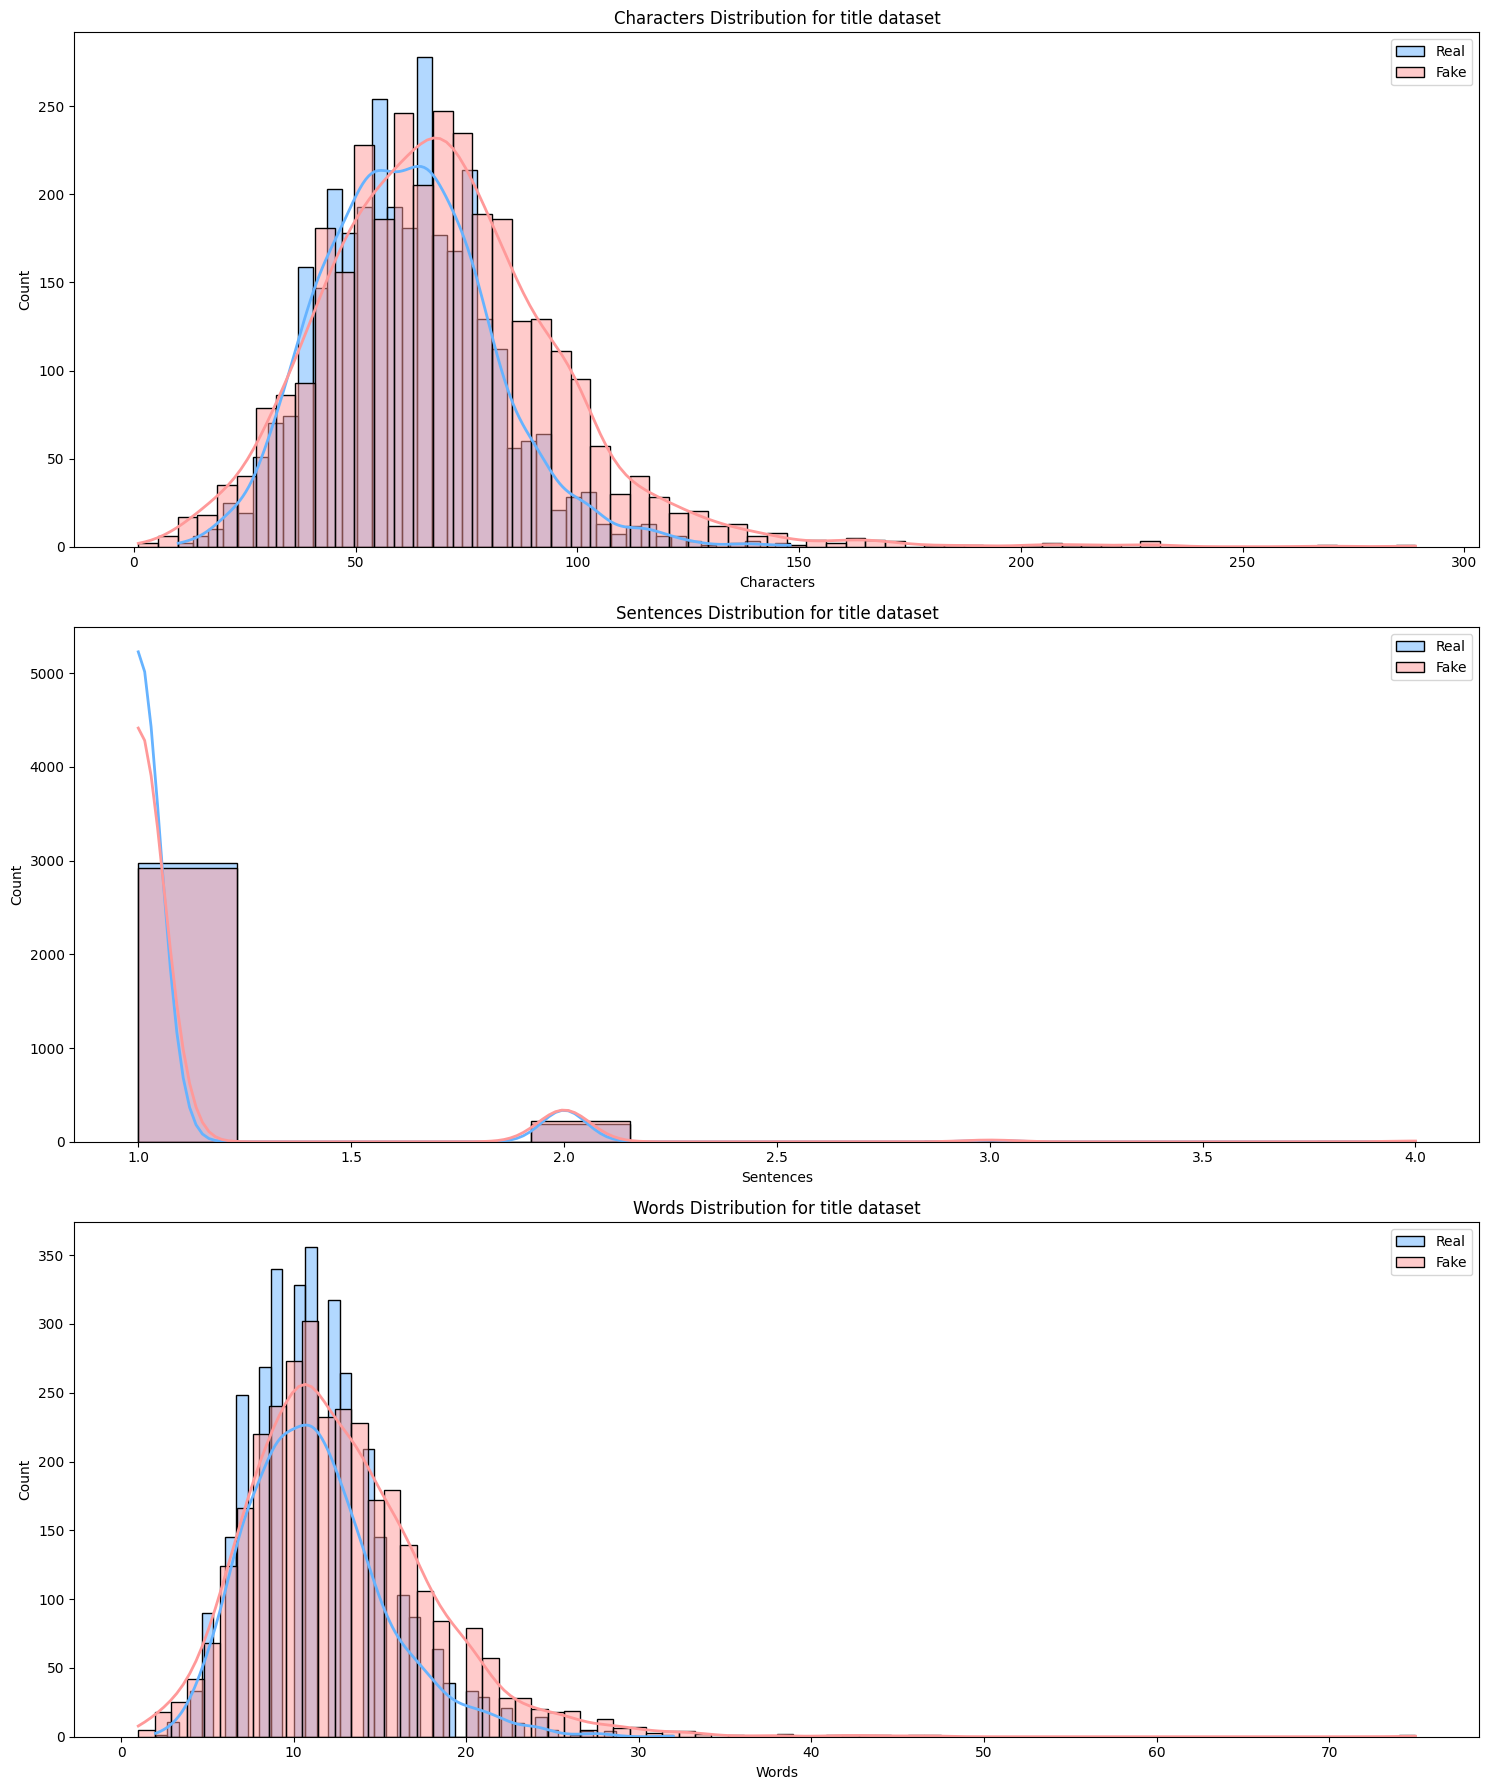

In [18]:
plot_distribution_features(df_title, ["Characters", "Sentences", "Words"], "title")

[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.


We have decided on the following metrics

Precision: Precision is the ratio of true positive predictions (correctly identifying fake news) to the total number of positive predictions (both true positives and false positives). Precision indicates the algorithm's ability to correctly identify fake news without mistakenly classifying real news as fake. In the context of fake news detection, precision is crucial because incorrectly labeling legitimate news as fake can have serious consequences, including reputational damage to news sources and misinformation propagation.

Recall (Sensitivity): Recall is the ratio of true positive predictions to the total number of actual positive instances (both true positives and false negatives). Recall measures the algorithm's ability to correctly identify all instances of fake news in the dataset. A high recall indicates that the algorithm can effectively detect most of the fake news samples, minimizing the risk of allowing misinformation to spread.

F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balanced assessment of the algorithm's performance by taking both precision and recall into account. The F1 score is particularly useful when there is an uneven distribution of classes in the dataset, as it considers false positives and false negatives.

Specificity: Specificity is the ratio of true negative predictions (correctly identifying real news) to the total number of actual negative instances (both true negatives and false positives). Specificity measures the algorithm's ability to correctly identify real news without mistakenly classifying it as fake. While precision focuses on the positive class (fake news), specificity provides insights into the algorithm's performance in accurately identifying the negative class (real news).

Area Under the Receiver Operating Characteristic Curve (AUC-ROC): The AUC-ROC is a widely used metric that evaluates the algorithm's overall performance across different threshold settings. It measures the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) at various classification thresholds. A higher AUC-ROC score indicates better overall performance, considering both true positives and true negatives.

[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice. 


We have decided to utilize Stratified 10-fold Cross-Validation:


Handling Class Imbalance: Since your dataset contains an equal distribution of fake news and real news samples, using stratified sampling ensures that each fold of the cross-validation maintains the same proportion of both classes. This is particularly important when dealing with imbalanced datasets, where one class is significantly more prevalent than the other. By maintaining class balance in each fold, the evaluation becomes more representative of the model's performance on unseen data.

Robust Performance Evaluation: Cross-validation provides a more robust estimate of your model's performance by iteratively training and testing the model on different subsets of the data. In Stratified 10-fold Cross-Validation, the dataset is divided into ten equal parts (folds), with each fold serving as the testing set once while the remaining nine folds are used for training. By averaging the performance metrics across all folds, you obtain a more reliable assessment of the model's generalization ability.

Mitigating Overfitting: Cross-validation helps in detecting and mitigating overfitting issues. Overfitting occurs when a model performs well on the training data but fails to generalize to unseen data. With Stratified 10-fold Cross-Validation, the model is exposed to multiple training and testing subsets. If the model consistently performs well across all folds, it indicates that it has learned patterns that are generalizable and not specific to a particular subset.

Optimal Hyperparameter Tuning: Cross-validation is commonly used for hyperparameter tuning. It allows you to evaluate different sets of hyperparameters on the training folds and select the best combination based on the average performance across the testing folds. This helps in finding the optimal hyperparameters that yield the best performance on unseen data.

Realistic Mirroring of Model Usage: Stratified 10-fold Cross-Validation provides a realistic reflection of how the model would be used in practice. It simulates the scenario where the model is trained on a large dataset and tested on unseen data. This approach is especially useful when you don't have a separate validation or holdout dataset for model evaluation.

### Modeling

[3 points] Investigate at least two different sequential network architectures (e.g., a CNN and a Transformer). Alternatively, you may also choose a recurrent network and Transformer network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust one hyper-parameter of each network to potentially improve generalization performance (train a total of at least four models). Visualize the performance of training and validation sets versus the training iterations, showing that the models converged.

In [20]:
# Code

[1 points] Using the best parameters and architecture from the Transformer in the previous step, add a second Multi-headed self attention layer to your network. That is, the input to the second attention layer should be the output sequence of the first attention layer.  Visualize the performance of training and validation sets versus the training iterations, showing that the model converged.. 


In [21]:
# Code

[2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the models you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  


In [22]:
# Code

### Exceptional Work

Use the pre-trained ConceptNet Numberbatch embedding and compare to pre-trained GloVe. Which method is better for your specific application? 


In [23]:
# Code for pre-trained ConceptNet Numberbatch embedding and pre-trained GloVe